In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.data import data_loaders
from JPAS_DA.data import generate_toy_data
from JPAS_DA.models import model_building_tools
from JPAS_DA.training import save_load_tools
from JPAS_DA.evaluation import evaluation_tools

import os
import torch
import numpy as np
from sklearn.manifold import TSNE

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib inline

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

In [2]:
# =========================
# Shared Parameters
# =========================
n_classes = 6
class_proportions = np.array([0.4, 0.1, 0.05, 0.2, 0.15, 0.1])
assert np.isclose(class_proportions.sum(), 1.0)

# sample sizes
n_samples_train    = 32768
n_samples_val      = 32768
n_samples_test     = 32768
n_samples_train_DA = 1024
n_samples_val_DA   = 1024

# seeds
seed_structure = 137
seed_train     = 42
seed_val       = 276
seed_test      = 0
seed_train_DA  = 1
seed_val_DA    = 2
seed_transform = 3

# =========================
# Create specs
# =========================
specs_target = [
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[0.0, 0.0], sigma=(1.5, 0.4), angle=np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[5.0, 1.0], sigma=(1.0, 0.2), angle=-np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[-2.0, -2.0], sigma=(0.6, 0.4), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[4.0, -6.0], sigma=(0.9, 0.6), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, -4.0], sigma=(0.4, 0.2), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[6.0, 2.0], sigma=(0.7, 0.7), angle=0),
    ], weights=[1.0]),
]

specs_source = [
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[0.0, 0.0], sigma=(1.5, 0.4), angle=np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, 0.0], sigma=(1.0, 0.2), angle=-np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[-5.0, -2.0], sigma=(0.6, 0.4), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, -4.0], sigma=(0.9, 0.6), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, -4.0], sigma=(0.4, 0.2), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[6.0, 2.0], sigma=(0.7, 0.7), angle=0),
    ], weights=[1.0]),
]

# =========================
# Generate Train/Val Source with the SAME shared specs and Target/Test with DIFFERENT shifted specs
# =========================
xx_train, yy_train, train_counts = generate_toy_data.generate_dataset_from_specs(
    n_samples_train, specs_source, class_proportions, seed=seed_train
)
xx_val, yy_val, val_counts = generate_toy_data.generate_dataset_from_specs(
    n_samples_val, specs_source, class_proportions, seed=seed_val
)
xx_test, yy_test, test_counts = generate_toy_data.generate_dataset_from_specs(
    n_samples_test, specs_target, class_proportions, seed=seed_test
)
xx_train_DA, yy_train_DA, _ = generate_toy_data.generate_dataset_from_specs(
    n_samples_train_DA, specs_target, class_proportions, seed=seed_train_DA
)
xx_val_DA, yy_val_DA, _ = generate_toy_data.generate_dataset_from_specs(
    n_samples_val_DA, specs_target, class_proportions, seed=seed_val_DA
)

In [3]:
path_load_Supervised = os.path.join(global_setup.path_models, "06_example_model_Supervised")
path_load_no_DA = os.path.join(global_setup.path_models, "06_example_model")
path_load_DA = os.path.join(global_setup.path_models, "07_example_model_DA")

In [4]:
dset_train_DA = data_loaders.DataLoader(xx_train_DA, yy_train_DA)
dset_val_no_DA = data_loaders.DataLoader(xx_val, yy_val)
dset_val_DA = data_loaders.DataLoader(xx_val_DA, yy_val_DA)
dset_test = data_loaders.DataLoader(xx_test, yy_test)

2025-11-07 07:40:37,501 - INFO - ├── 💿 Initializing DataLoader object with 1024 samples...
2025-11-07 07:40:37,501 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 409 (39.94%), 1: 102 (9.96%), 2: 51 (4.98%), 3: 204 (19.92%), 4: 153 (14.94%), 5: 105 (10.25%)]
2025-11-07 07:40:37,501 - INFO - ├── 💿 Initializing DataLoader object with 32768 samples...
2025-11-07 07:40:37,502 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 13107 (40.00%), 1: 3276 (10.00%), 2: 1638 (5.00%), 3: 6553 (20.00%), 4: 4915 (15.00%), 5: 3279 (10.01%)]
2025-11-07 07:40:37,502 - INFO - ├── 💿 Initializing DataLoader object with 1024 samples...
2025-11-07 07:40:37,502 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 409 (39.94%), 1: 102 (9.96%), 2: 51 (4.98%), 3: 204 (19.92%), 4: 153 (14.94%), 5: 105 (10.25%)]
2025-11-07 07:40:37,502 - INFO - ├── 💿 Initializing DataLoader object with 32768 samples...
2025-11-07 07:40:37,503 - INFO - ├── ✔ Finished Initialization. Class dis

In [5]:
_, model_encoder_Supervised = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_Supervised, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_Supervised = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_Supervised, "model_downstream.pt"), model_building_tools.create_mlp)
model_encoder_Supervised.eval()
model_downstream_Supervised.eval()

_, model_encoder_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_downstream.pt"), model_building_tools.create_mlp)
model_encoder_no_DA.eval()
model_downstream_no_DA.eval()

_, model_encoder_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_downstream.pt"), model_building_tools.create_mlp)
model_encoder_DA.eval()
model_downstream_DA.eval()

_ = evaluation_tools.compare_model_parameters(model_downstream_no_DA, model_downstream_DA, rtol=1e-2, atol=1e-2)

config {'input_dim': 2, 'hidden_layers': [16, 16], 'dropout_rates': [0.01, 0.01], 'output_dim': 2, 'use_batchnorm': True, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [16], 'dropout_rates': [0.01], 'output_dim': 4, 'use_batchnorm': True, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [24, 16, 8], 'dropout_rates': [0.01, 0.01, 0.01], 'output_dim': 2, 'use_batchnorm': False, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [16, 16], 'dropout_rates': [0.01, 0.01], 'output_dim': 6, 'use_batchnorm': False, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [24, 16, 8], 'dropout_rates': [0.01, 0.01, 0.01], 'output_dim': 2, 'use_batchnorm': False, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [16, 16], 'dropout_rates': [0.01, 0.01], 'o

In [6]:
xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_Supervised(xx)
        logits = model_downstream_Supervised(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)
yy_true_test_Supervised = yy_true.cpu().numpy()
features_test_Supervised= features_.cpu().numpy()
yy_pred_P_test_Supervised = yy_pred_P.cpu().numpy()
yy_pred_test_Supervised = np.argmax(yy_pred_P_test_Supervised, axis=1)



xx, yy_true = dset_val_no_DA(batch_size=dset_val_no_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)
yy_true_val_no_DA = yy_true.cpu().numpy()
features_val_no_DA = features_.cpu().numpy()
yy_pred_P_val_no_DA = yy_pred_P.cpu().numpy()
yy_pred_val_no_DA = np.argmax(yy_pred_P_val_no_DA, axis=1)


xx, yy_true = dset_train_DA(batch_size=dset_train_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)
yy_true_train_DA = yy_true.cpu().numpy()
features_train_DA = features_.cpu().numpy()
yy_pred_P_train_DA = yy_pred_P.cpu().numpy()
yy_pred_train_DA = np.argmax(yy_pred_P_train_DA, axis=1)


xx, yy_true = dset_val_DA(batch_size=dset_val_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)
yy_true_val_DA = yy_true.cpu().numpy()
features_val_DA = features_.cpu().numpy()
yy_pred_P_val_DA = yy_pred_P.cpu().numpy()
yy_pred_val_DA = np.argmax(yy_pred_P_val_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)
yy_true_test = yy_true.cpu().numpy()
features_test_no_DA = features_.cpu().numpy()
yy_pred_P_test_no_DA = yy_pred_P.cpu().numpy()
yy_pred_test_no_DA = np.argmax(yy_pred_P_test_no_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)
yy_true_test = yy_true.cpu().numpy()
features_test_DA = features_.cpu().numpy()
yy_pred_P_test_DA = yy_pred_P.cpu().numpy()
yy_pred_test_DA = np.argmax(yy_pred_P_test_DA, axis=1)

/home/dlopez/tmp/pip-tmp/ipykernel_65917/3188256430.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


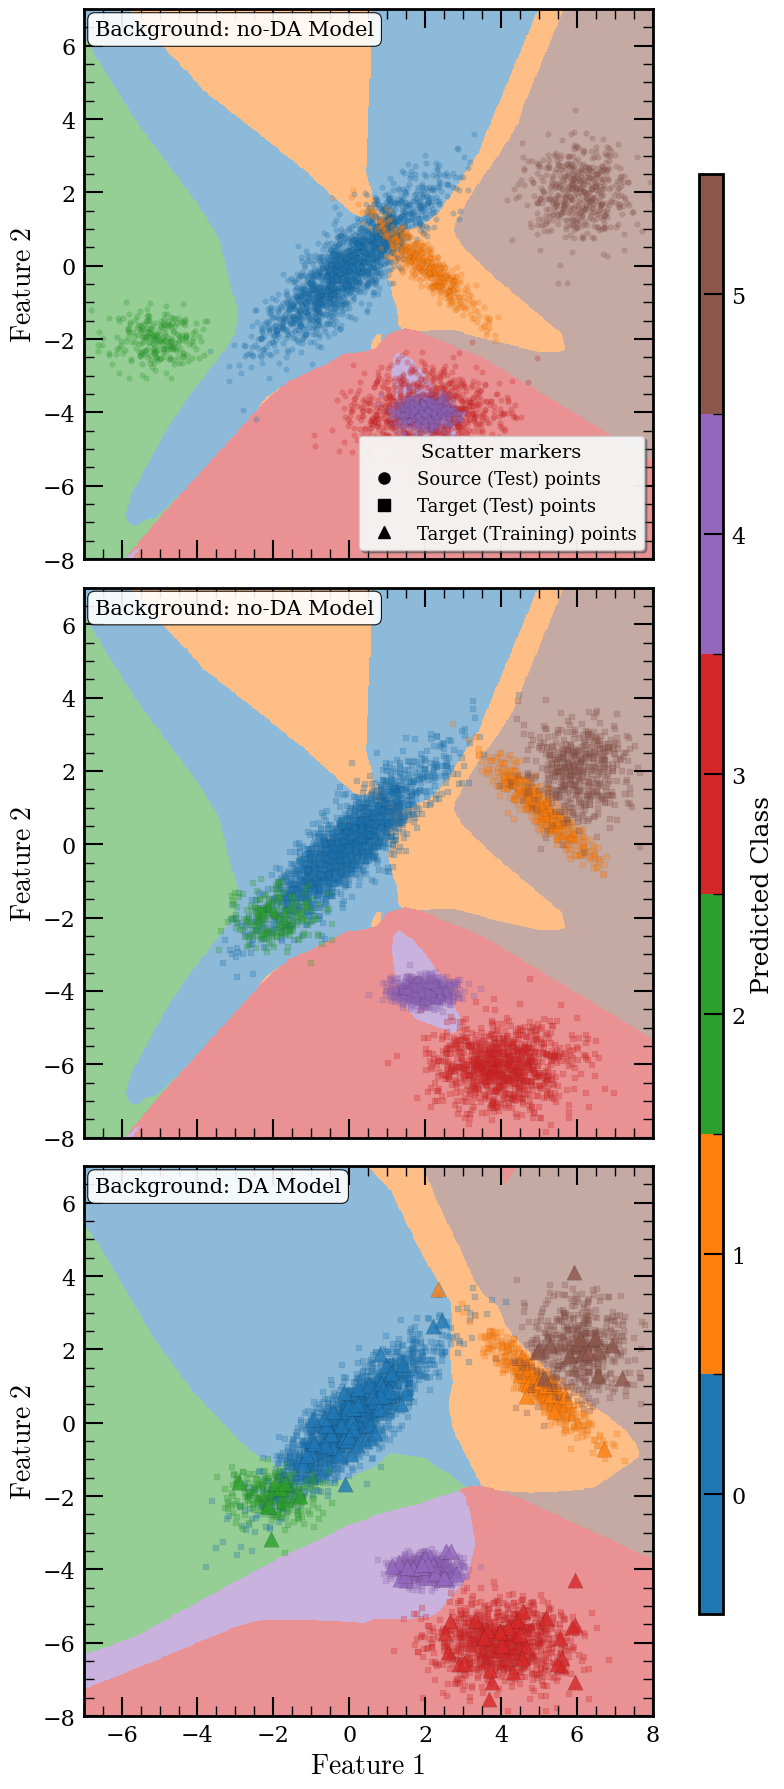

In [7]:
# =========================
# Subsampling options (set to None for no subsampling)
# =========================
SUBSAMPLE_SOURCE_VAL   = 0.15   # e.g., 0.2 for 20% per-class, or 500 for max 500 pts per class
SUBSAMPLE_TARGET_TEST  = 0.15   # e.g., 0.2 or 500
SUBSAMPLE_TARGET_TRAIN = 0.15   # optional: subsample DA-train overlay (panel 3)
SUBSAMPLE_SEED         = 42

rng = np.random.default_rng(SUBSAMPLE_SEED)

def _select_indices_per_class(mask_bool, max_or_frac, rng):
    """
    From a boolean mask, return a subset of indices.
    - If max_or_frac is None -> all indices.
    - If 0 < max_or_frac < 1 (float) -> that fraction of indices.
    - If >=1 (int/float) -> up to that many indices (min with available).
    """
    idx_all = np.flatnonzero(mask_bool)
    if max_or_frac is None:
        return idx_all
    n = len(idx_all)
    if n == 0:
        return idx_all
    if isinstance(max_or_frac, float) and 0 < max_or_frac < 1:
        k = max(1, int(np.floor(n * max_or_frac)))
    else:
        k = min(n, int(max_or_frac))
    return rng.choice(idx_all, size=k, replace=False)

# =========================
# Global style parameters
# =========================
FS_TICK         = 16  # tick labels
FS_LABEL        = 20  # axis labels
FS_BOX          = 15  # info box text
FS_LEGEND       = 13  # legend text
FS_LEGEND_TITLE = 14  # legend title
FS_CBAR_LABEL   = 18  # colorbar label
FS_CBAR_TICK    = 16  # colorbar ticks

INFOBOX_BBOX = dict(boxstyle='round,pad=0.35', facecolor='white',
                    alpha=0.9, edgecolor='black', linewidth=0.8)

# =========================
# Bounds & grid
# =========================
x_min, x_max = -7, 8
y_min, y_max = -8, 7
grid_res = 512

xx_vals = np.linspace(x_min, x_max, grid_res)
yy_vals = np.linspace(y_min, y_max, grid_res)
xx_mesh, yy_mesh = np.meshgrid(xx_vals, yy_vals)
grid_points = np.stack([xx_mesh.ravel(), yy_mesh.ravel()], axis=1)

# Build the grid tensor on CPU, move to the model's device for each forward pass
xx_grid_cpu = torch.tensor(grid_points, dtype=torch.float32, device="cpu")

# =========================
# Colors (consistent across panels)
# =========================
class_labels = np.unique(dset_val_no_DA.yy["SPECTYPE_int"])
n_classes = len(class_labels)

cmap = plt.cm.get_cmap("tab10")
class_colors = np.array(cmap.colors[:n_classes])

norm = mpl.colors.BoundaryNorm(np.arange(n_classes + 1) - 0.5, ncolors=n_classes)

# =========================
# Helper: annotate panels (ONLY background info)
# =========================
def add_info_box(ax, bg_desc):
    txt = f"Background: {bg_desc}"
    ax.text(0.02, 0.98, txt, transform=ax.transAxes,
            va='top', ha='left', fontsize=FS_BOX, bbox=INFOBOX_BBOX)

# =========================
# Helper: predict on grid
# =========================
def predict_grid(encoder, downstream, xx_grid_cpu, device):
    with torch.no_grad():
        feats = encoder(xx_grid_cpu.to(device))
        logits = downstream(feats)
        yy_pred = torch.softmax(logits, dim=1).argmax(dim=1)
    Z = yy_pred.view(grid_res, grid_res).cpu().numpy().astype(float)
    return Z

# Devices (assume models are already on appropriate devices)
dev_no_DA = next(model_encoder_no_DA.parameters()).device
dev_DA    = next(model_encoder_DA.parameters()).device

# =========================
# Compute predicted grids
# =========================
Z_Supervised = predict_grid(model_encoder_Supervised, model_downstream_Supervised, xx_grid_cpu, dev_no_DA)  # NEW
Z_noDA_val  = predict_grid(model_encoder_no_DA, model_downstream_no_DA, xx_grid_cpu, dev_no_DA)
Z_noDA_test = Z_noDA_val  # same models; reuse prediction for test overlay
Z_DA_test   = predict_grid(model_encoder_DA, model_downstream_DA, xx_grid_cpu, dev_DA)

# =========================
# Figure with THREE VERTICAL PANELS (shared axes)
# =========================
fig, axes = plt.subplots(3, 1, figsize=(8, 18), sharex=True, sharey=True)

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(labelsize=FS_TICK)

# Left y-labels on all panels; shared x-label on the bottom
for ax in axes:
    ax.set_ylabel(r"$\mathrm{Feature~2}$", fontsize=FS_LABEL)
axes[-1].set_xlabel(r"$\mathrm{Feature~1}$", fontsize=FS_LABEL)

# =========================
# Panel 0: no-DA + SOURCE (validation) points
# =========================
ax_val = axes[0]
ax_val.pcolormesh(xx_mesh, yy_mesh, Z_noDA_val, cmap=cmap, norm=norm,
                  shading='nearest', alpha=0.5)

for i, label in enumerate(class_labels):
    mask = (dset_val_no_DA.yy["SPECTYPE_int"] == label)
    idx_sel = _select_indices_per_class(mask, SUBSAMPLE_SOURCE_VAL, rng)
    if idx_sel.size == 0:
        continue
    pts = dset_val_no_DA.xx["OBS"][idx_sel]
    ax_val.scatter(pts[:, 0], pts[:, 1], s=16, alpha=0.3, color=class_colors[i],
                   edgecolor='black', linewidth=0.1)  # default marker 'o'

add_info_box(ax_val, "no-DA Model")

# =========================
# Panel 1: no-DA + TARGET (test) points
# =========================
ax_noDA_test = axes[1]
ax_noDA_test.pcolormesh(xx_mesh, yy_mesh, Z_noDA_test, cmap=cmap, norm=norm,
                        shading='nearest', alpha=0.5)

for i, label in enumerate(class_labels):
    mask = (dset_test.yy["SPECTYPE_int"] == label)
    idx_sel = _select_indices_per_class(mask, SUBSAMPLE_TARGET_TEST, rng)
    if idx_sel.size == 0:
        continue
    pts = dset_test.xx["OBS"][idx_sel]
    ax_noDA_test.scatter(pts[:, 0], pts[:, 1], marker='s', s=16, alpha=0.3, color=class_colors[i],
                         edgecolor='black', linewidth=0.1)

add_info_box(ax_noDA_test, "no-DA Model")

# =========================
# Panel 2: DA + TARGET (test) points + TARGET (train) points
# =========================
ax_DA_test = axes[2]
ax_DA_test.pcolormesh(xx_mesh, yy_mesh, Z_DA_test, cmap=cmap, norm=norm,
                      shading='nearest', alpha=0.5)

for i, label in enumerate(class_labels):
    # Target test (subsample)
    mask_test = (dset_test.yy["SPECTYPE_int"] == label)
    idx_sel_test = _select_indices_per_class(mask_test, SUBSAMPLE_TARGET_TEST, rng)
    if idx_sel_test.size:
        pts_test = dset_test.xx["OBS"][idx_sel_test]
        ax_DA_test.scatter(pts_test[:, 0], pts_test[:, 1], marker='s', s=16, alpha=0.3, color=class_colors[i],
                           edgecolor='black', linewidth=0.1)

    # DA train (optional subsample)
    mask_train = (dset_train_DA.yy["SPECTYPE_int"] == label)
    idx_sel_train = _select_indices_per_class(mask_train, SUBSAMPLE_TARGET_TRAIN, rng)
    if idx_sel_train.size:
        pts_train = dset_train_DA.xx["OBS"][idx_sel_train]
        ax_DA_test.scatter(pts_train[:, 0], pts_train[:, 1], marker='^', s=120, alpha=0.8, color=class_colors[i],
                           edgecolor='black', linewidth=0.1)

add_info_box(ax_DA_test, "DA Model")

# =========================
# Marker legend (first subpanel only, black symbols, uniform size)
# =========================
from matplotlib.lines import Line2D
marker_handles = [
    Line2D([0], [0], marker='o', linestyle='None', color='black', markersize=8,
           label='Source (Test) points'),
    Line2D([0], [0], marker='s', linestyle='None', color='black', markersize=8,
           label='Target (Test) points'),
    Line2D([0], [0], marker='^', linestyle='None', color='black', markersize=8,
           label='Target (Training) points'),
]
ax_val.legend(handles=marker_handles, loc='lower right',
              title="Scatter markers", title_fontsize=FS_LEGEND_TITLE,
              fontsize=FS_LEGEND, fancybox=True, shadow=True, framealpha=0.9)

# =========================
# Shared colorbar on the RIGHT
# =========================
plt.tight_layout(rect=[0.0, 0.0, 0.85, 1.0])  # leave room for colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cax = fig.add_axes([0.88, 0.10, 0.03, 0.80])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Predicted Class", fontsize=FS_CBAR_LABEL)
cbar.ax.tick_params(labelsize=FS_CBAR_TICK)
cbar.set_ticks(np.arange(n_classes))
try:
    cbar.set_ticklabels([str(lbl) for lbl in class_labels])
except Exception:
    pass

plt.savefig(os.path.join(global_setup.path_saved_figures, "toy_distributions_tripanel.png"),
            format="png", bbox_inches="tight")
plt.show()


In [8]:
class_names = np.arange(n_classes)

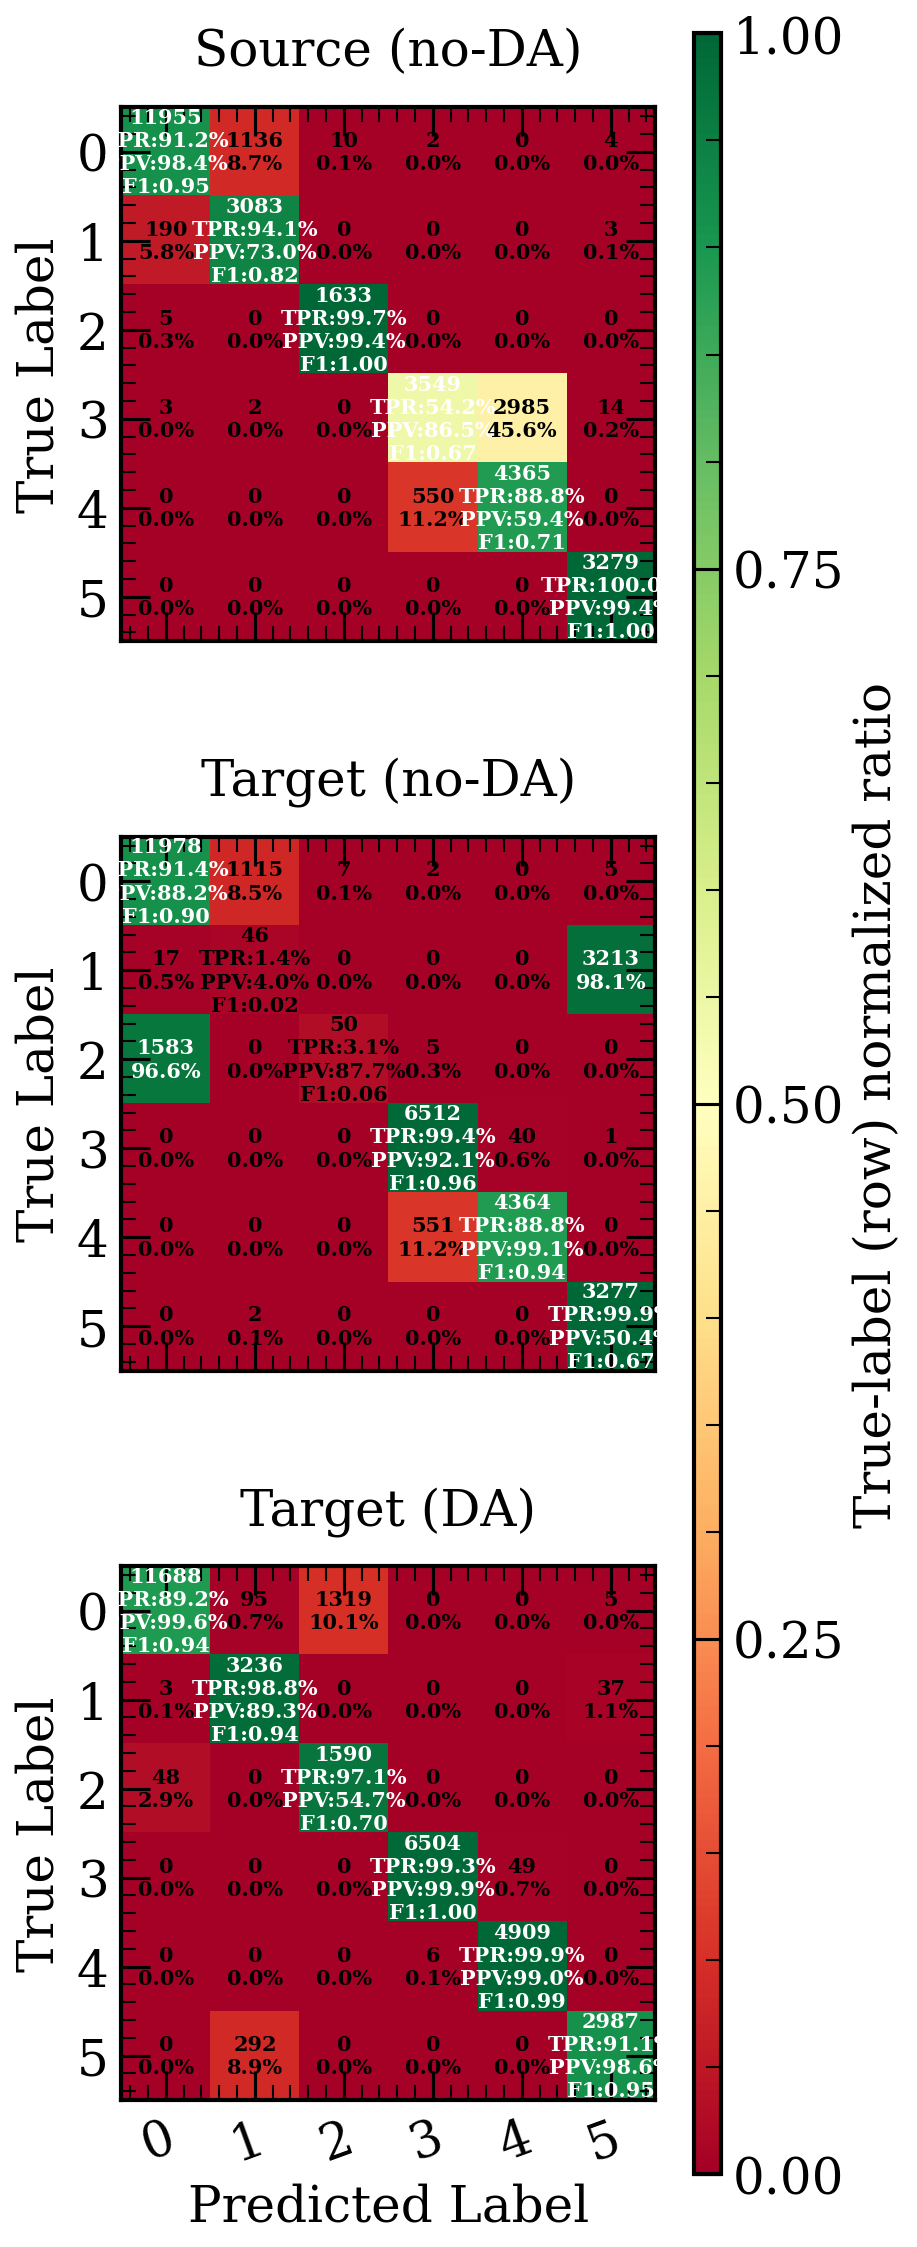

In [9]:
dict_cm = {
    "Source (no-DA)": {
        "y_true": yy_true_val_no_DA,
        "y_pred": yy_pred_P_val_no_DA,
    },
    "Target (no-DA)": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_no_DA,
    },
    "Target (DA)": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_DA,
    },
}

fig, axes = evaluation_tools.plot_confusion_matrices_grid(
    dict_cases=dict_cm,
    class_names=class_names, cmap="RdYlGn",
    figsize=(6, 15), ncols=1, nrows=3, fs_cell=10, fs_cell_diag=10,
    save_path=os.path.join(global_setup.path_saved_figures, "toy_model_confusion_matrices.pdf"),
)
plt.show()


=== Global Metrics Table ===
Metric          | Source no-DA | JPAS Obs. no-DA | JPAS Obs. DA
----------------+--------------+-----------------+-------------
Accuracy        |       0.8503 |          0.8004 |       0.9434
Macro F1        |       0.8565 |          0.5901 |       0.9193
Macro TPR       |       0.8800 |          0.6399 |       0.9587
Macro Precision |       0.8602 |          0.7026 |       0.9018
Macro AUROC     |       0.9865 |          0.9010 |       0.9957
ECE             |       0.0219 |          0.2006 |       0.0463



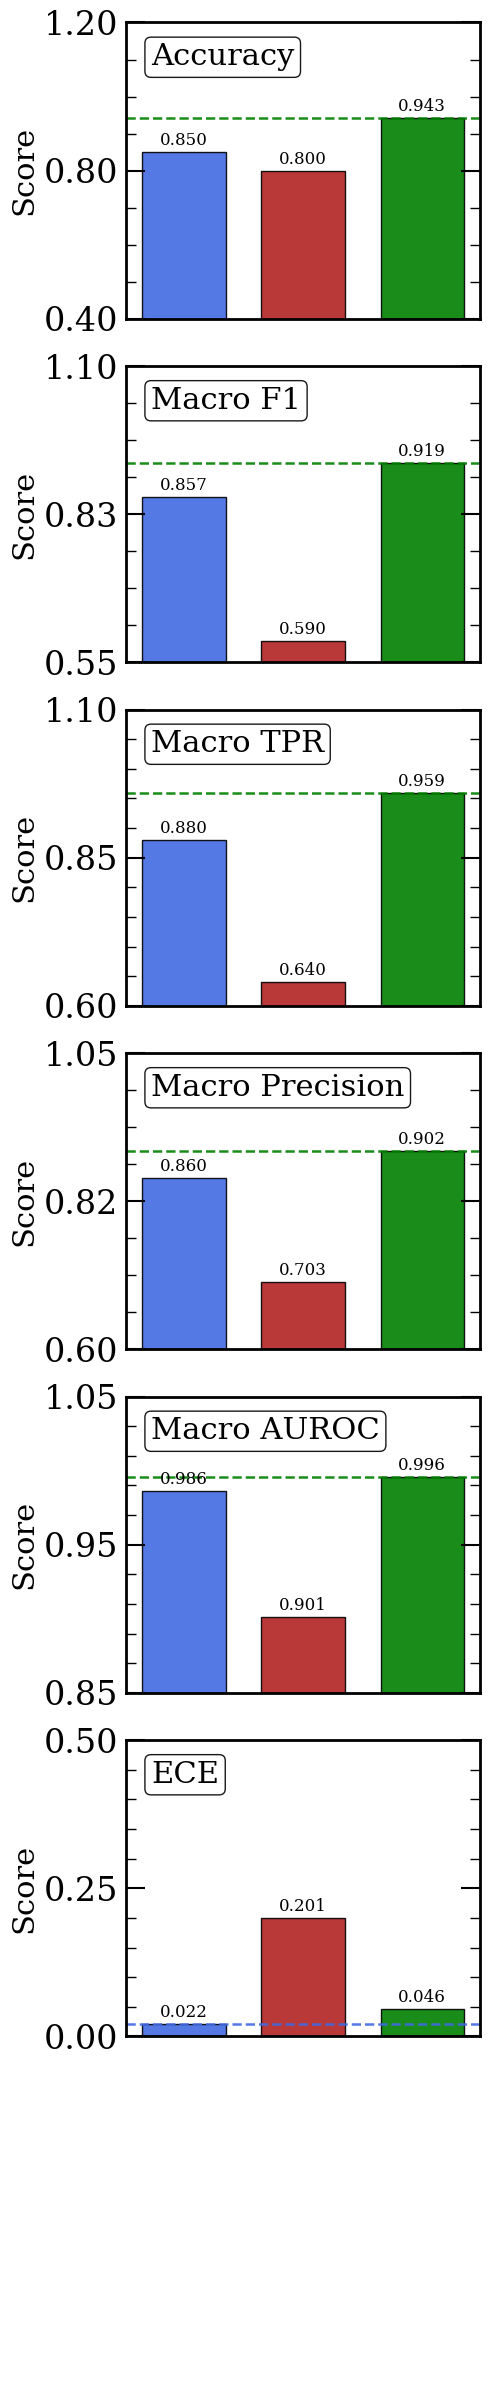

In [10]:
dict_cmp = {
    "Source no-DA": {
        "y_true": yy_true_val_no_DA,
        "y_pred": yy_pred_P_val_no_DA,
        "plot_kwargs": {"color": "royalblue", "label": "Source no-DA"},
    },
    "Target no-DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_no_DA,
        "plot_kwargs": {"color": "firebrick", "label": "JPAS Obs. no-DA"},
    },
    "Target DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_DA,
        "plot_kwargs": {"color": "green", "label": "JPAS Obs. DA"},
    },
}
fig, axes = evaluation_tools.compare_models_performance(
    dict_cases=dict_cmp,
    class_names=class_names,
    title=None,
    figsize=(5, 24),
    palette=["grey", "royalblue", "firebrick", "darkorange", "green"],
    save_path=os.path.join(global_setup.path_saved_figures, "toy_model_metrics_comparison.pdf"),
    include_metrics=("Accuracy", "Macro F1", "Macro TPR", "Macro Precision", "Macro AUROC", "ECE"),
    nrows=7,
    subplot_hspace=-1.166,
    subplot_wspace=0.25,
    ylabel_text="Score",
    y_ranges={
        "Accuracy":        (0.4, 1.2),
        "Macro F1":        (0.55, 1.1),
        "Macro TPR":       (0.6, 1.1),
        "Macro Precision": (0.6, 1.05),
        "Macro AUROC":     (0.85, 1.05),
        "ECE":             (0.0, 0.5)
    },
    y_margin_frac=0.07,
    bar_alpha=0.9,
    bar_edgecolor="black",
    bar_width=0.7,
    annotate_values=True,
    value_label_fontsize=12,
)
plt.show()

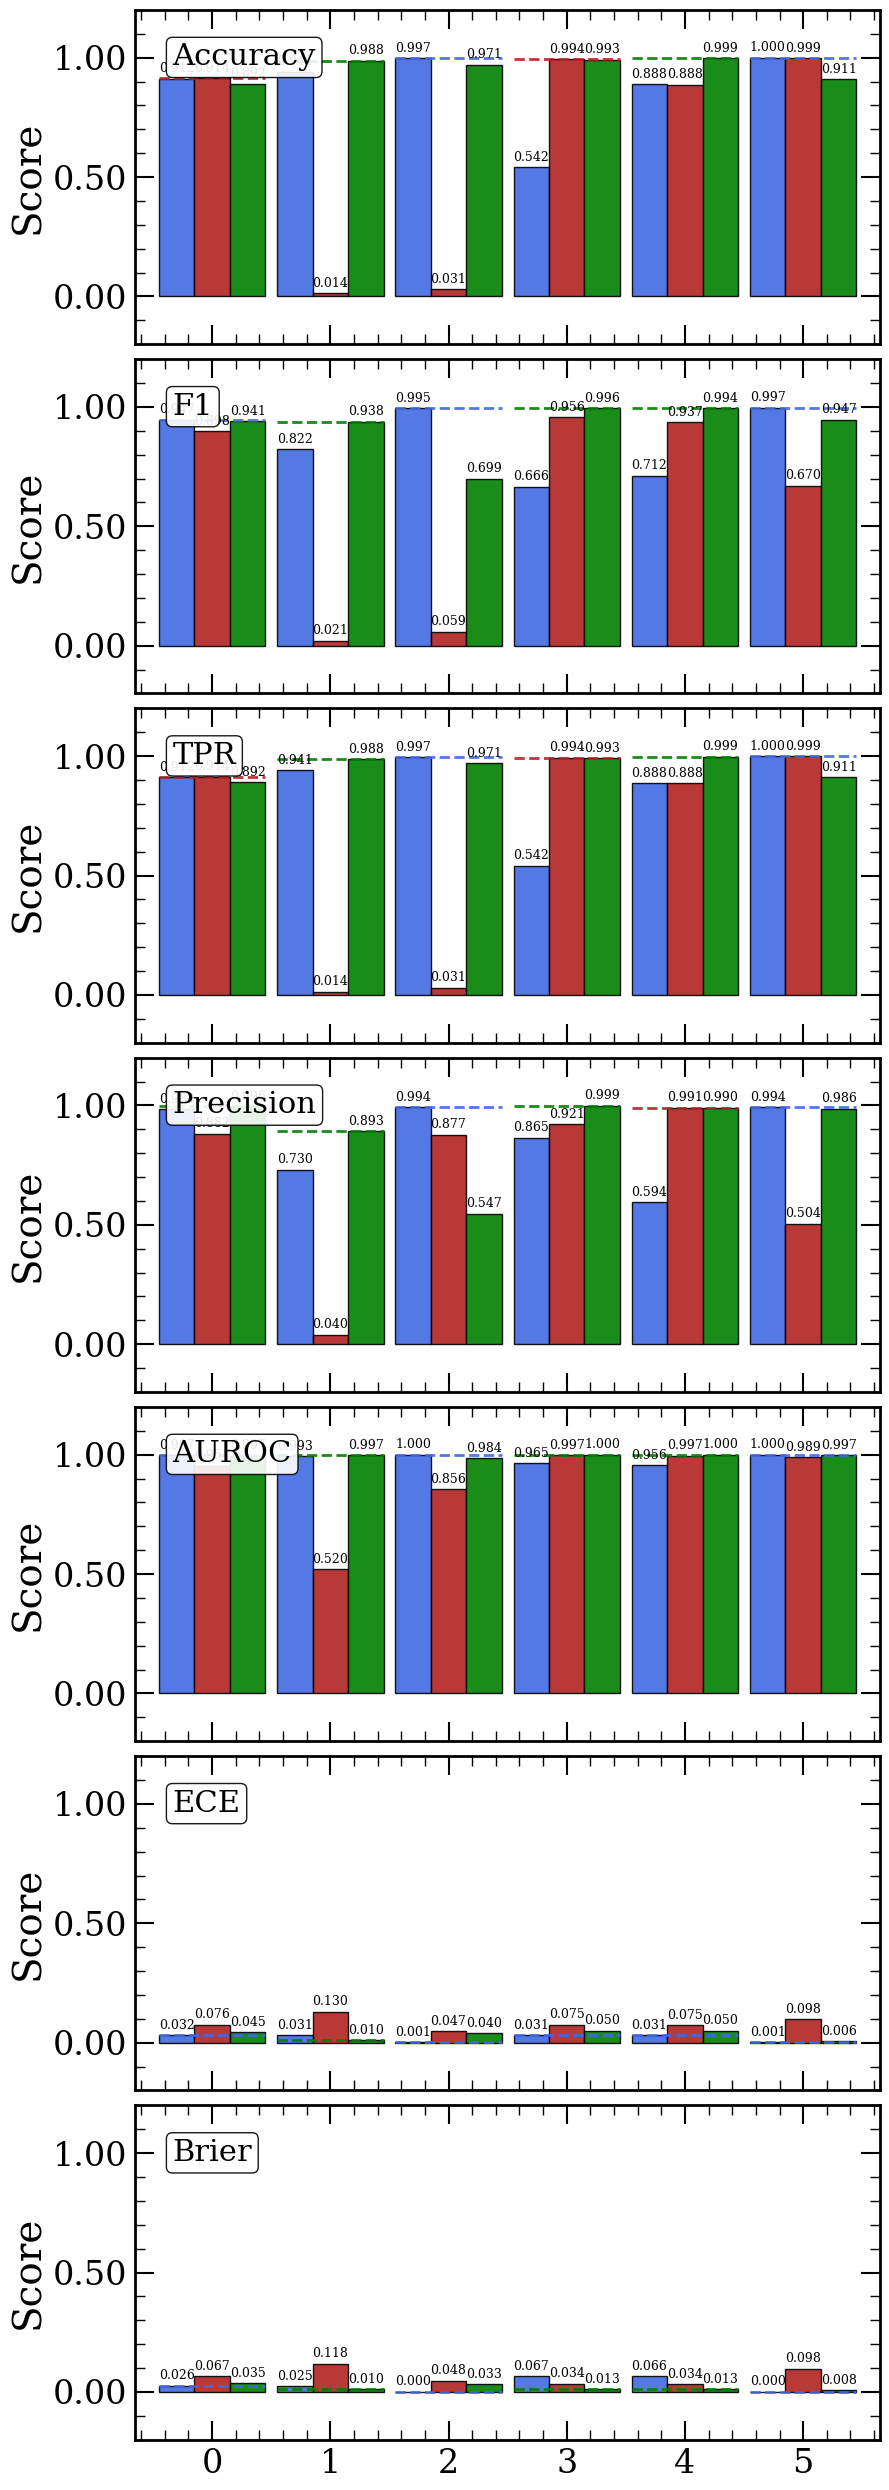

In [11]:
fig, axes = evaluation_tools.compare_models_performance_per_class(
    dict_cases=dict_cmp, class_names=class_names, title=None,
    figsize=(9, 25),
    palette=["grey", "royalblue", "firebrick", "darkorange", "green"],
    save_path=None, #os.path.join(global_setup.path_saved_figures, "toy_model_metrics_comparison_per_class.pdf"),
    include_metrics=("Accuracy", "F1", "TPR", "Precision", "AUROC", "ECE", "Brier"),
    nrows=7, subplot_hspace=0.5, subplot_wspace=0.25,
    y_ranges={
        "Accuracy":  (-0.2, 1.2),
        "F1":        (-0.2, 1.2),
        "TPR":       (-0.2, 1.2),
        "Precision": (-0.2, 1.2),
        "AUROC":     (-0.2, 1.2),
        "ECE":       (-0.2, 1.2),
        "Brier":     (-0.2, 1.2),
    },
    y_margin_frac=0.07, bar_alpha=0.9, bar_edgecolor="black", group_width=0.9,
    annotate_values=True, value_label_fontsize=9, ylabel_text="Score", left_margin=0.10,
    ytick_step=0.05, ytick_format="{x:.2f}", two_line_class_xticklabels=False,
)
fig.tight_layout()
plt.show()

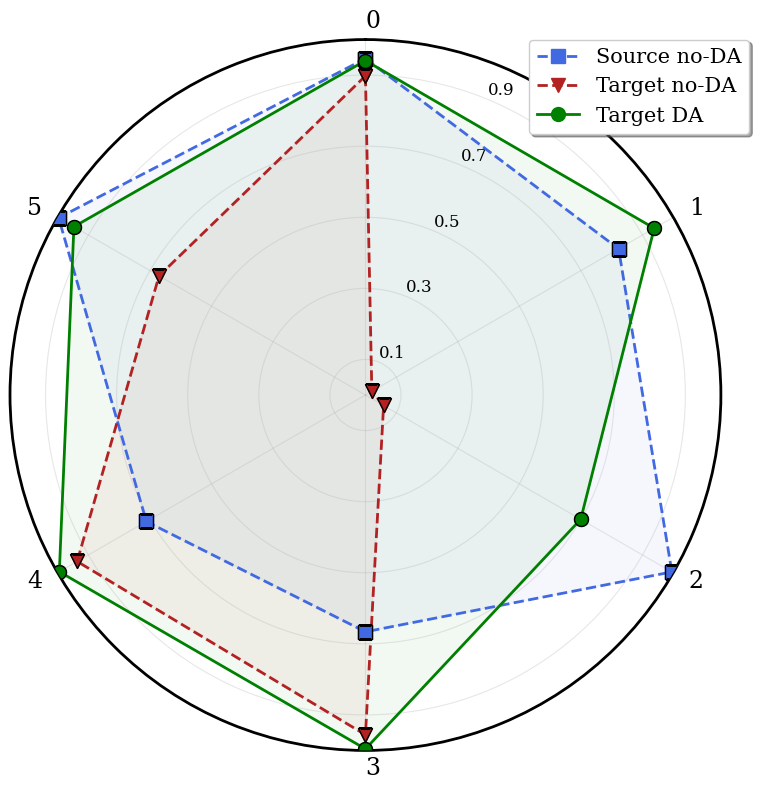

In [12]:
dict_radar = {
    "Source no-DA": {
        "y_true": yy_true_val_no_DA,
        "y_pred": yy_pred_P_val_no_DA,
        "plot_kwargs": {
            "linestyle": "--", "linewidth": 2.0, "color": "royalblue",
            "marker": "s", "markersize": 10.0, "fill_alpha": 0.05,
            "label": "Source no-DA",
        },
    },
    "Target no-DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_no_DA,
        "plot_kwargs": {
            "linestyle": "--", "linewidth": 2.0, "color": "firebrick",
            "marker": "v", "markersize": 10.0, "fill_alpha": 0.05,
            "label": "Target no-DA",
        },
    },
    "Target DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_DA,
        "plot_kwargs": {
            "linestyle": "-", "linewidth": 2.0, "color": "green",
            "marker": "o", "markersize": 10.0, "fill_alpha": 0.05,
            "label": "Target DA",
        },
    },
}

fig, ax = evaluation_tools.radar_plot(
    dict_radar=dict_radar,
    class_names=class_names,
)
fig.savefig(os.path.join(global_setup.path_saved_figures, "toy_model_F1_radar.pdf"), bbox_inches='tight')
plt.show()

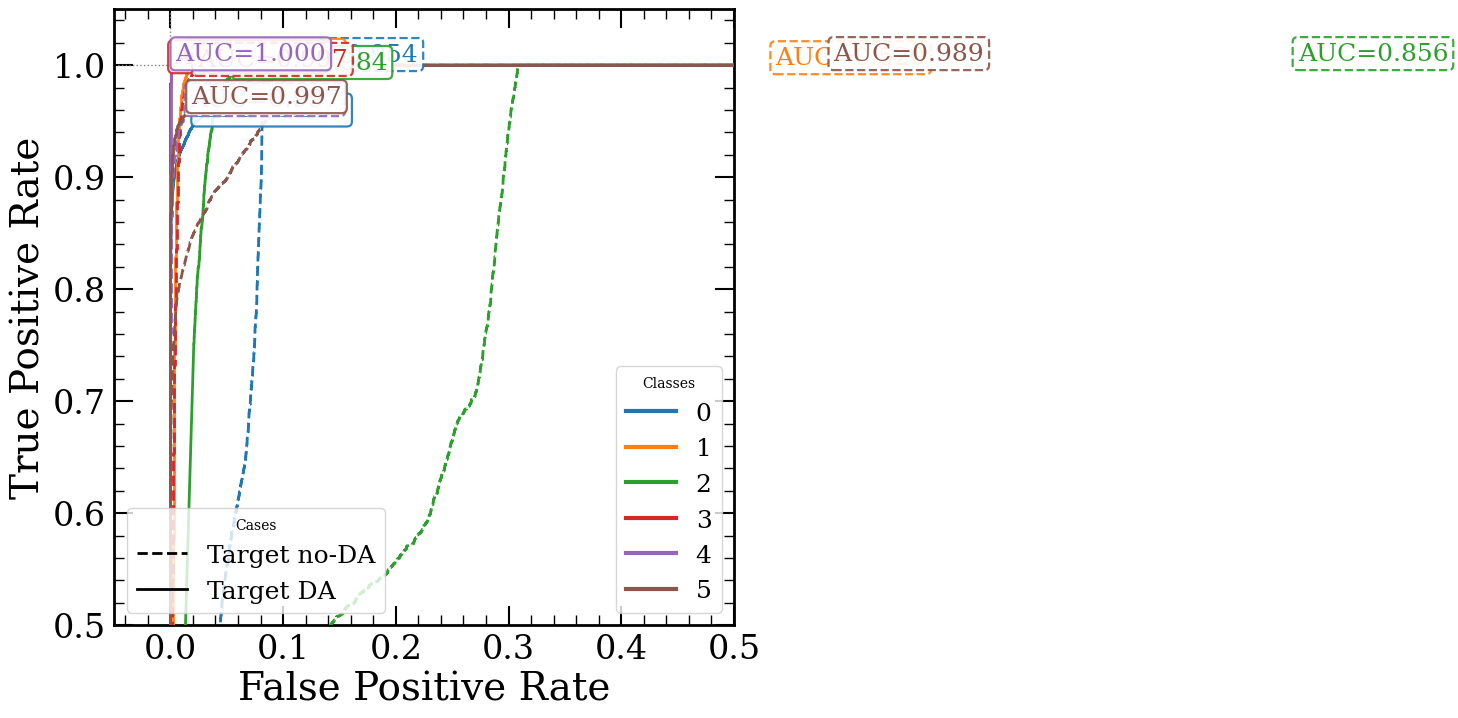

In [13]:
dict_roc = {
    "Target no-DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_no_DA,
        "plot_kwargs": {"linestyle": "--", "linewidth": 2.0, "marker": None, "markersize": 8,
                        "label": "Target no-DA"},
    },
    "Target DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_DA,
        "plot_kwargs": {"linestyle": "-", "linewidth": 2.0, "marker": None, "markersize": 8,
                        "label": "Target DA"},
    },
}

fig, ax = evaluation_tools.plot_multiclass_rocs(
    dict_cases=dict_roc,
    class_names=class_names,
    title=None,
    x_lims=(-0.05, 0.5),
    y_lims=(0.5, 1.05),
)
ax.axhline(1, color="grey", linestyle=":", linewidth=1.0)
ax.axvline(0, color="grey", linestyle=":", linewidth=1.0)
fig.savefig(os.path.join(global_setup.path_saved_figures, "toy_model_ROC.pdf"), format="pdf", bbox_inches="tight")
plt.show()


# Explore latent space

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_latent_scatter_with_bg(
    xx_mesh, yy_mesh, Z_bg, *,      # background grid & classes
    cmap, norm,                     # background colormap + BoundaryNorm matching class ids
    dict_cases,                     # {case: {"points":(N,2), "labels":(N,), "label":str, "marker":str, "size":float, "alpha":float, "edgecolor":str,"linewidth":float, "subsample":float|int|None, "class_colors":{class_id:color}|None}}
    figsize=(7, 7),
    x_lims=None, y_lims=None,
    z_bg_alpha=0.5,
    per_class_subsample=True,       # subsample per class (stratified) if True; else global
    legend_loc="lower right",
    legend_title="Point clouds",
    legend_fontsize=12,
    add_colorbar=False,
    cbar_label="Predicted Class",
    cbar_ticklabels=None,           # list of class labels to show on colorbar
    seed=42
):
    """
    dict_cases[case] keys:
      - points: np.ndarray (N,2)
      - labels: np.ndarray (N,) of class ids (ints) matching `norm` bins
      - label:  legend entry for this case (str)
      - marker: e.g. 'o', 's', '^' (default 'o')
      - size:   marker size (default 8)
      - alpha:  float (default 0.4)
      - edgecolor: e.g. 'black' or None (default 'black')
      - linewidth: float (default 0.1)
      - subsample: None (no sub), float in (0,1] as fraction, or int as max count
      - class_colors: dict {class_id: color}; if missing, colors are taken from (c=labels, cmap, norm)
    """
    rng = np.random.default_rng(seed)

    def _sub_idx(mask, subspec):
        idx = np.flatnonzero(mask)
        if subspec is None or idx.size == 0:
            return idx
        if isinstance(subspec, float) and 0 < subspec <= 1:
            k = max(1, int(np.floor(idx.size * subspec)))
        else:
            k = min(idx.size, int(subspec))
        return rng.choice(idx, size=k, replace=False)

    fig, ax = plt.subplots(figsize=figsize)

    # Background
    ax.pcolormesh(xx_mesh, yy_mesh, Z_bg, cmap=cmap, norm=norm, shading='nearest', alpha=z_bg_alpha)

    # Axis limits
    if x_lims is not None:
        ax.set_xlim(*x_lims)
    if y_lims is not None:
        ax.set_ylim(*y_lims)

    # Plot each case
    legend_handles = []
    for case_name, cfg in dict_cases.items():
        pts   = np.asarray(cfg["points"])
        labs  = np.asarray(cfg["labels"]).astype(int)

        marker    = cfg.get("marker", "o")
        msize     = cfg.get("size", 8)
        alpha     = cfg.get("alpha", 0.4)
        ecolor    = cfg.get("edgecolor", "black")
        lw        = cfg.get("linewidth", 0.1)
        subspec   = cfg.get("subsample", None)
        label     = cfg.get("label", case_name)
        cls_cols  = cfg.get("class_colors", None)  # dict {class_id: color}

        if per_class_subsample:
            idx_sel_list = []
            for c in np.unique(labs):
                idx_sel_list.append(_sub_idx(labs == c, subspec))
            idx_sel = np.concatenate(idx_sel_list) if idx_sel_list else np.array([], dtype=int)
        else:
            # global subsample
            all_mask = np.ones(labs.size, dtype=bool)
            idx_sel = _sub_idx(all_mask, subspec)

        if idx_sel.size == 0:
            # still add legend handle to document the case
            legend_handles.append(Line2D([0],[0], marker=marker, linestyle="None",
                                         color="black", markersize=max(6, np.sqrt(msize)),
                                         label=label))
            continue

        pts = pts[idx_sel]
        labs = labs[idx_sel]

        if cls_cols is None:
            # Color by class via cmap/norm in one call
            ax.scatter(pts[:, 0], pts[:, 1],
                       c=labs, cmap=cmap, norm=norm,
                       s=msize, alpha=alpha, marker=marker,
                       edgecolor=ecolor, linewidth=lw)
        else:
            # Color by class using custom mapping; plot per class for correct colors
            for c in np.unique(labs):
                p = pts[labs == c]
                ax.scatter(p[:, 0], p[:, 1],
                           color=cls_cols.get(c, "gray"),
                           s=msize, alpha=alpha, marker=marker,
                           edgecolor=ecolor, linewidth=lw)

        # Legend handle: show marker/style in black (as requested)
        legend_handles.append(Line2D([0],[0], marker=marker, linestyle="None",
                                     color="black", markersize=max(6, np.sqrt(msize)),
                                     label=label))

    # Legend (one entry per case, black markers, uniform size)
    if legend_handles:
        ax.legend(handles=legend_handles, loc=legend_loc, fontsize=legend_fontsize,
                  title=legend_title, frameon=True)

    # Optional colorbar for background classes
    if add_colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(cbar_label)
        if cbar_ticklabels is not None:
            cbar.set_ticks(np.arange(len(cbar_ticklabels)))
            cbar.set_ticklabels([str(t) for t in cbar_ticklabels])

    ax.set_xlabel("Latent 1")
    ax.set_ylabel("Latent 2")
    ax.set_aspect("equal")

    return fig, ax


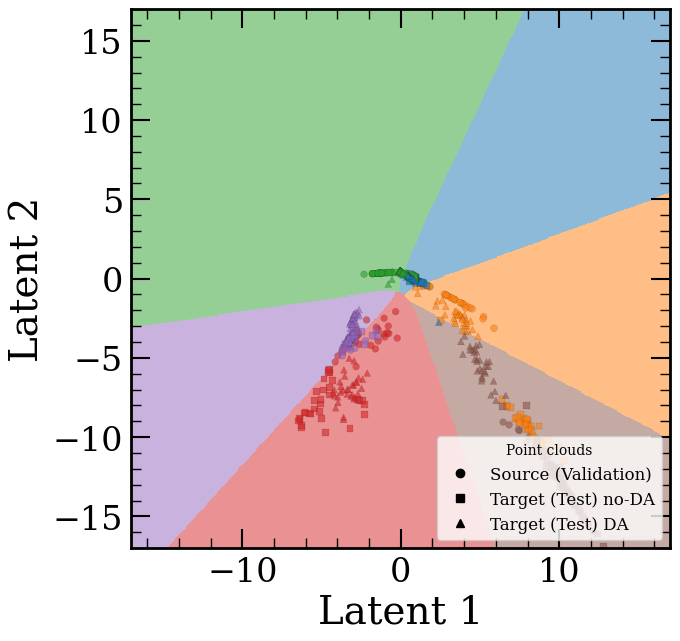

In [15]:
# Build a per-class color map (e.g., plasma) if you want custom colors per class:
# class_labels = np.unique(yy_true_val_no_DA)
# n_classes = len(class_labels)
# cmap_base = plt.cm.get_cmap("plasma", n_classes)
# class_colors = [cmap_base(i) for i in range(n_classes)]
# class_color_map = {int(class_labels[i]): class_colors[i] for i in range(n_classes)}

dict_cases = {
    "Source (Val)": {
        "points": features_val_no_DA, "labels": yy_true_val_no_DA, "label": "Source (Validation)",
        "marker": "o", "size": 24, "alpha": 0.6, "edgecolor": "black", "linewidth": 0.1,
        "subsample": 32,
        # "class_colors": class_color_map,     # uncomment to force your own per-class colors
    },
    "Target (Test) no-DA": {
        "points": features_test_no_DA, "labels": yy_true_test, "label": "Target (Test) no-DA",
        "marker": "s", "size": 24, "alpha": 0.6, "edgecolor": "black", "linewidth": 0.1,
        "subsample": 32,
        # "class_colors": class_color_map,
    },
    "Target (Test) DA": {
        "points": features_test_DA, "labels": yy_true_test, "label": "Target (Test) DA",
        "marker": "^", "size": 24, "alpha": 0.6, "edgecolor": "black", "linewidth": 0.1,
        "subsample": 32,
        # "class_colors": class_color_map,
    },
}

x_min, x_max = -17, 17
y_min, y_max = -17, 17
grid_res = 512
xx_vals = np.linspace(x_min, x_max, grid_res)
yy_vals = np.linspace(y_min, y_max, grid_res)
xx_mesh, yy_mesh = np.meshgrid(xx_vals, yy_vals)
grid_points = np.stack([xx_mesh.ravel(), yy_mesh.ravel()], axis=1)
feats_grid_cpu = torch.tensor(grid_points, dtype=torch.float32, device="cpu")
with torch.no_grad():
    logits_feats_grid = model_downstream_no_DA(feats_grid_cpu.to("cpu"))
    yy_pred_grid = torch.softmax(logits_feats_grid, dim=1).argmax(dim=1)
Z_grid = yy_pred_grid.view(grid_res, grid_res).cpu().numpy().astype(float)

fig, ax = plot_latent_scatter_with_bg(
    xx_mesh, yy_mesh, Z_grid,
    cmap=cmap, norm=norm,
    dict_cases=dict_cases,
    figsize=(7, 7),
    x_lims=(-17, 17), y_lims=(-17, 17),
    z_bg_alpha=0.5,
    per_class_subsample=True,
    legend_loc="lower right",
    legend_title="Point clouds",
    legend_fontsize=12,
    add_colorbar=False,               # set True if you want a colorbar for the background
    cbar_label="Predicted Class",
    cbar_ticklabels=None,             # or list(class_labels) if you want class names
    seed=42
)
plt.show()

In [16]:
feat_dict = {
    "latents_grid": np.array(feats_grid_cpu.to("cpu")),
    "latents_no_DA_Source": features_val_no_DA,
    "latents_no_DA_Target": features_test_no_DA,
    "latents_DA_Target": features_test_DA
}

latents_tSNE = evaluation_tools.tsne_per_key(
    feat_dict,
    standardize=False,
    subsample=None,
    random_state=137,
    tsne_kwargs={"perplexity": 100},
    return_all_key=None,
)

2025-11-07 07:40:41,435 - INFO - t-SNE on N=360448 (perplexity=100)...


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 360448 samples in 0.061s...
[t-SNE] Computed neighbors for 360448 samples in 8.947s...
[t-SNE] Computed conditional probabilities for sample 1000 / 360448
[t-SNE] Computed conditional probabilities for sample 2000 / 360448
[t-SNE] Computed conditional probabilities for sample 3000 / 360448
[t-SNE] Computed conditional probabilities for sample 4000 / 360448
[t-SNE] Computed conditional probabilities for sample 5000 / 360448
[t-SNE] Computed conditional probabilities for sample 6000 / 360448
[t-SNE] Computed conditional probabilities for sample 7000 / 360448
[t-SNE] Computed conditional probabilities for sample 8000 / 360448
[t-SNE] Computed conditional probabilities for sample 9000 / 360448
[t-SNE] Computed conditional probabilities for sample 10000 / 360448
[t-SNE] Computed conditional probabilities for sample 11000 / 360448
[t-SNE] Computed conditional probabilities for sample 12000 / 360448
[t-SNE] Computed conditional probab

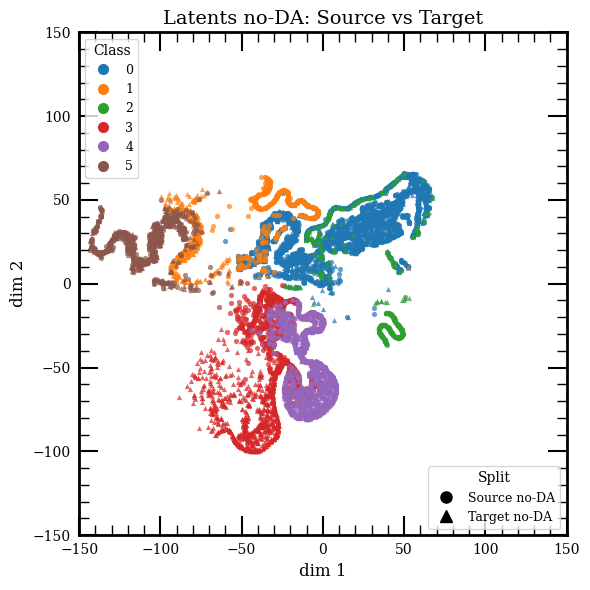

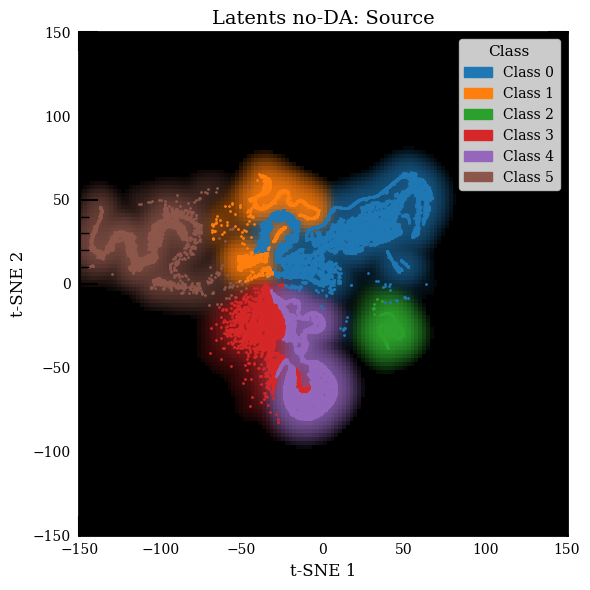

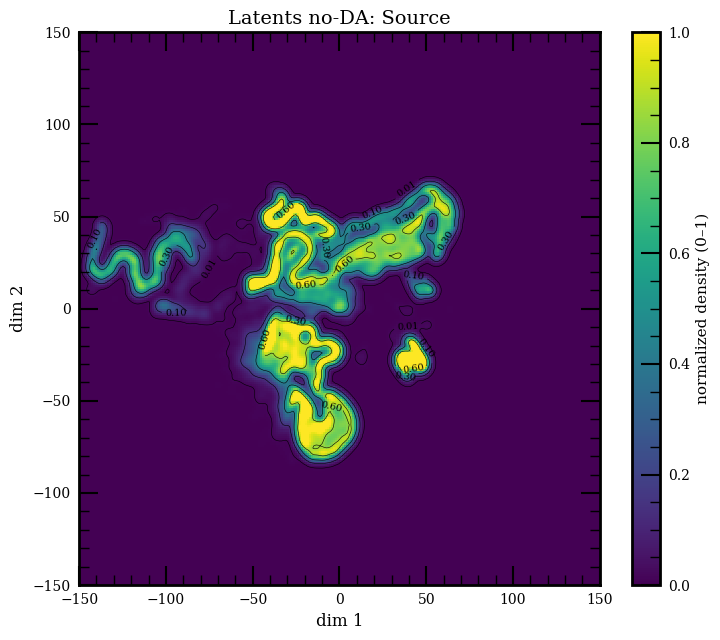

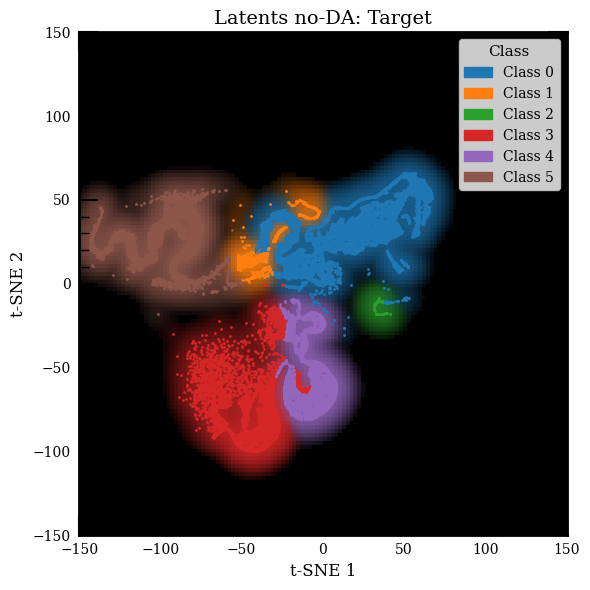

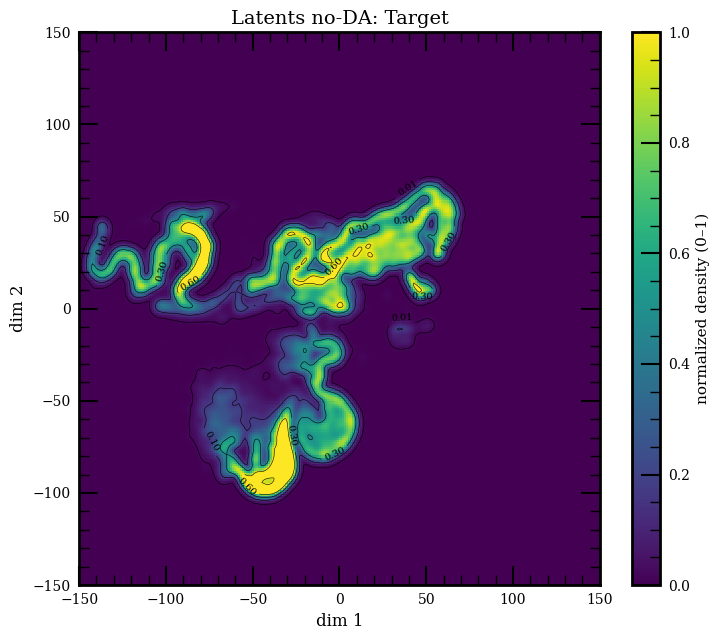

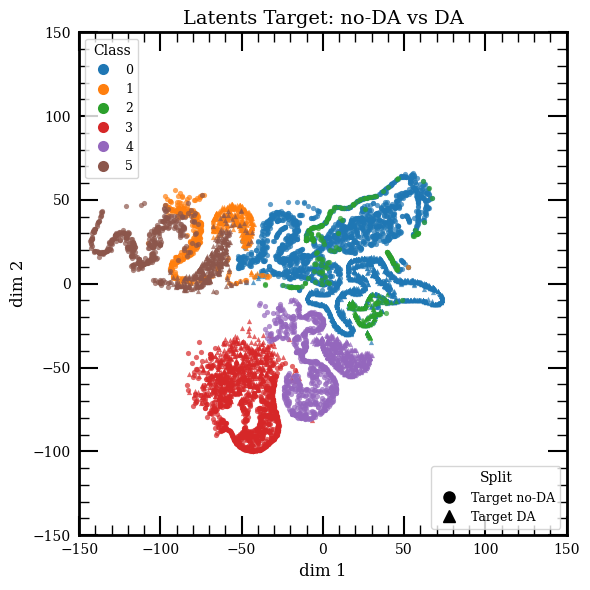

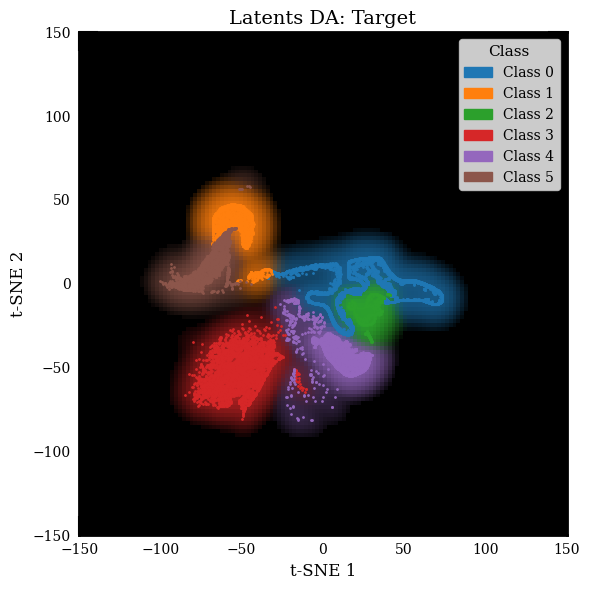

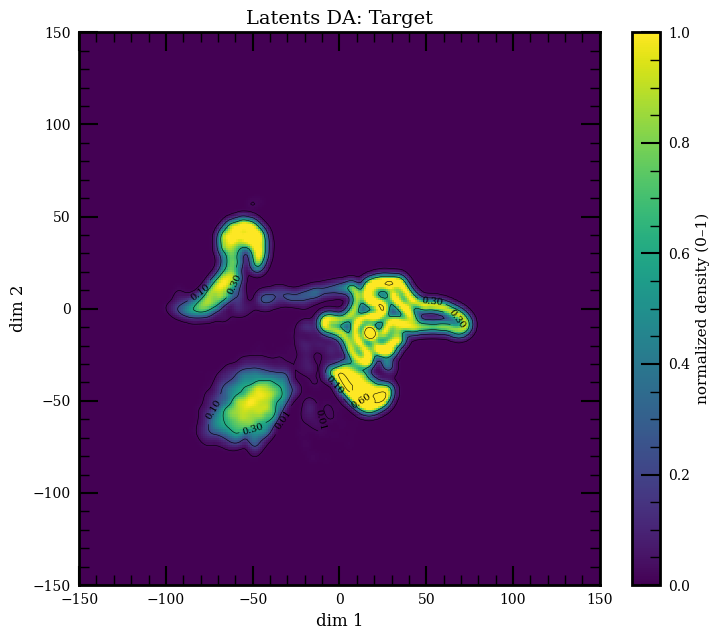

In [17]:
xlim = (-150, 150)
ylim = (-150, 150)

evaluation_tools.plot_latents_scatter_val_test(
    X_val=latents_tSNE['latents_no_DA_Source_tSNE'], y_val=yy_true_val_no_DA,
    X_test=latents_tSNE['latents_no_DA_Target_tSNE'], y_test=yy_true_test,
    class_names=None,
    title="Latents no-DA: Source vs Target",
    marker_val="o", marker_test="^",
    size_val=14, size_test=14, alpha_val=0.7, alpha_test=0.7,
    xlim=xlim, ylim=ylim,
    subsample=4000, seed=137,
    edgecolor=None, linewidths=0.0,
    legend_split_1="Source no-DA",
    legend_split_2="Target no-DA"
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_no_DA_Source_tSNE'], yy_pred_val_no_DA, # yy_true_val_no_DA
    class_counts=dset_val_no_DA.class_counts,
    class_names=None,
    title="Latents no-DA: Source",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_no_DA_Source_tSNE'],
    title="Latents no-DA: Source",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_no_DA_Target_tSNE'], yy_pred_test_no_DA, # yy_true_test
    class_counts=dset_test.class_counts,
    class_names=None,
    title="Latents no-DA: Target",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_no_DA_Target_tSNE'],
    title="Latents no-DA: Target",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)

evaluation_tools.plot_latents_scatter_val_test(
    X_val=latents_tSNE['latents_no_DA_Target_tSNE'], y_val=yy_true_test,
    X_test=latents_tSNE['latents_DA_Target_tSNE'], y_test=yy_true_test,
    class_names=None,
    title="Latents Target: no-DA vs DA",
    marker_val="o", marker_test="^",
    size_val=14, size_test=14, alpha_val=0.7, alpha_test=0.7,
    xlim=xlim, ylim=ylim,
    subsample=4000, seed=137,
    edgecolor=None, linewidths=0.0,
    legend_split_1="Target no-DA",
    legend_split_2="Target DA"
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_DA_Target_tSNE'], yy_pred_test_DA, # yy_true_test
    class_counts=dset_test.class_counts,
    class_names=None,
    title="Latents DA: Target",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_DA_Target_tSNE'],
    title="Latents DA: Target",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)

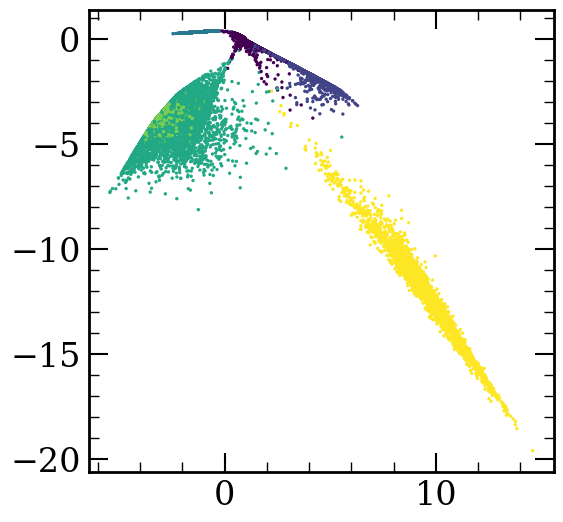

In [18]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 6))
scatter = ax.scatter(latents_tSNE['latents_no_DA_Source'][:, 0], latents_tSNE['latents_no_DA_Source'][:, 1],
                     c=yy_true_val_no_DA, s=2)